In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import json

import sys
sys.path.append('../src')


from utils.preprocess import combine_bands, equalize_histogram, adjust_brightness_contrast

In [2]:
# Diretórios das bandas de treinamento
train_red_dir = '../data/raw/38-Cloud_training/train_red'
train_green_dir = '../data/raw/38-Cloud_training/train_green'
train_blue_dir = '../data/raw/38-Cloud_training/train_blue'
train_gt_dir = '../data/raw/38-Cloud_training/train_gt'

# Diretórios para salvar os dados processados
processed_images_dir = '../data/processed/38-Cloud/images/train/'
processed_masks_dir = '../data/processed/38-Cloud/masks/train/'

os.makedirs(processed_images_dir, exist_ok=True)
os.makedirs(processed_masks_dir, exist_ok=True)

In [3]:
red_files = sorted(os.listdir(train_red_dir))
green_files = sorted(os.listdir(train_green_dir))
blue_files = sorted(os.listdir(train_blue_dir))
mask_files = sorted(os.listdir(train_gt_dir))

print(f'Número de arquivos de banda vermelha: {len(red_files)}')
print(f'Número de arquivos de banda verde: {len(green_files)}')
print(f'Número de arquivos de banda azul: {len(blue_files)}')
print(f'Número de máscaras: {len(mask_files)}')

Número de arquivos de banda vermelha: 8400
Número de arquivos de banda verde: 8400
Número de arquivos de banda azul: 8400
Número de máscaras: 8400


In [4]:
def remove_band_prefix(filename):
    base_name = os.path.splitext(filename)[0]
    prefixes = ['red_', 'green_', 'blue_', 'gt_']
    for prefix in prefixes:
        if base_name.startswith(prefix):
            base_name = base_name[len(prefix):]
            break
    return base_name

In [5]:
# Verificar se os nomes dos arquivos correspondem entre as bandas e as máscaras
for r_file, g_file, b_file, m_file in zip(red_files, green_files, blue_files, mask_files):
    base_name_r = remove_band_prefix(r_file)
    base_name_g = remove_band_prefix(g_file)
    base_name_b = remove_band_prefix(b_file)
    base_name_m = remove_band_prefix(m_file)
    
    if not (base_name_r == base_name_g == base_name_b == base_name_m):
        print(f'Arquivos não correspondentes: {r_file}, {g_file}, {b_file}, {m_file}')

Aplicando o Pré-processamento

In [6]:
# Definindo os parâmetros de pré-processamento
brightness_factor = 1.0 
contrast_factor = 1.0    
apply_histogram_equalization = True

Problemas na normalização - `RuntimeWarning: invalid value encountered in divide`

Imagens Uniformes: Se uma imagem (banda) possui todos os pixels com o mesmo valor, então red_array.max() == red_array.min(). Isso faz com que o denominador seja zero.

Variância Zero: Uma imagem com variância zero (sem variação na intensidade dos pixels) causará esse problema durante a normalização.

Solução: Verificar se red_array.max() - red_array.min() é zero e, se for, definir o array normalizado como zeros ou um valor constante.

In [7]:
# Função principal para processar e salvar as imagens e máscaras
for r_file, g_file, b_file, m_file in tqdm(zip(red_files, green_files, blue_files, mask_files), total=len(red_files)):
    base_name = remove_band_prefix(r_file)
    
    red_path = os.path.join(train_red_dir, r_file)
    green_path = os.path.join(train_green_dir, g_file)
    blue_path = os.path.join(train_blue_dir, b_file)
    mask_path = os.path.join(train_gt_dir, m_file)
    
    # Combinar as bandas
    image = combine_bands(red_path, green_path, blue_path)
    
    # Aplicar equalização de histograma
    if apply_histogram_equalization:
        image = equalize_histogram(image)
    
    # Ajuste de brilho e contraste
    image = adjust_brightness_contrast(image, brightness_factor, contrast_factor)
    
    # Carregar a máscara
    mask = Image.open(mask_path).convert('L')
    mask_array = np.array(mask)
    # Converter a máscara para valores binários (0 e 1)
    mask_array = (mask_array > 0).astype(np.uint8) * 255
    mask = Image.fromarray(mask_array)
    
    # Salvando as imagens processadas
    image.save(os.path.join(processed_images_dir, f"{base_name}.png"))
    mask.save(os.path.join(processed_masks_dir, f"{base_name}.png"))

100%|██████████| 8400/8400 [11:28<00:00, 12.20it/s]


Verificando os Dados Processados

In [8]:
processed_image_files = sorted(os.listdir(processed_images_dir))
processed_mask_files = sorted(os.listdir(processed_masks_dir))

print(f'Número de imagens processadas: {len(processed_image_files)}')
print(f'Número de máscaras processadas: {len(processed_mask_files)}')

Número de imagens processadas: 8400
Número de máscaras processadas: 8400


Visualizando Algumas Imagens e Máscaras Processadas

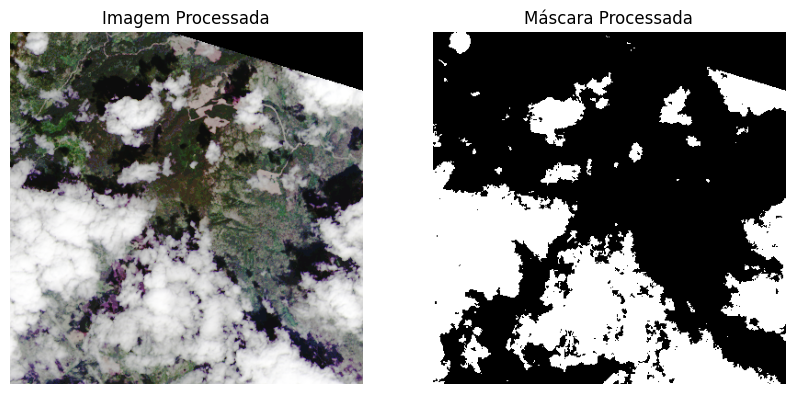

In [13]:
def visualize_processed_image_and_mask(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Imagem Processada')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara Processada')
    plt.axis('off')
    
    plt.show()

# Selecionando uma imagem aleatória
idx = random.randint(0, len(processed_image_files) - 1)
image_path = os.path.join(processed_images_dir, processed_image_files[idx])
mask_path = os.path.join(processed_masks_dir, processed_mask_files[idx])

visualize_processed_image_and_mask(image_path, mask_path)

Função para Divisão dos Dados

In [16]:
def split_data(image_files, test_size=0.15, val_size=0.15, random_state=42):
    train_val_files, test_files = train_test_split(
        image_files, test_size=test_size, random_state=random_state
    )
    val_ratio = val_size / (1 - test_size)
    train_files, val_files = train_test_split(
        train_val_files, test_size=val_ratio, random_state=random_state
    )
    return train_files, val_files, test_files

Dividindo e Salvando as Divisões

In [17]:
# Dividindo os dados
train_files, val_files, test_files = split_data(processed_image_files)

print(f"Número de imagens de treinamento: {len(train_files)}")
print(f"Número de imagens de validação: {len(val_files)}")
print(f"Número de imagens de teste: {len(test_files)}")

Número de imagens de treinamento: 5880
Número de imagens de validação: 1260
Número de imagens de teste: 1260


In [18]:
# Salvando as divisões
splits_dir = os.path.join('../data/processed/38-Cloud/', 'splits/')
os.makedirs(splits_dir, exist_ok=True)

with open(os.path.join(splits_dir, 'train_files.json'), 'w') as f:
    json.dump(train_files, f)
with open(os.path.join(splits_dir, 'val_files.json'), 'w') as f:
    json.dump(val_files, f)
with open(os.path.join(splits_dir, 'test_files.json'), 'w') as f:
    json.dump(test_files, f)